# L5: DPO

DPO（直接偏好优化）是一种对比学习方法，它同时从正样本（优选）和负样本（劣选）中学习。  

在这个实验中，我们将从一个小的 Qwen instruct 模型开始。这个模型有自己的身份标识“Qwen”。当用户问“你是谁？”时，它会回答“我是 Qwen”。然后，我们创建一些对比数据。具体来说，当询问身份时，我们将身份名称从“Qwen”改为“Deep Qwen”，并使用“Deep Qwen”作为正样本（优选回答），“Qwen”作为负样本（劣选回答）。我们使用了一个大规模（数量）的对比数据集，并在现有的 instruct 模型之上进行 DPO 排序训练。之后，我们将得到一个微调后的 Qwen 模型，它拥有了新的身份。当用户问“你是谁？”时，希望模型会回答“我是 Deep Qwen”。
![DPO in Practice.png](<attachment:DPO in Practice.png>)

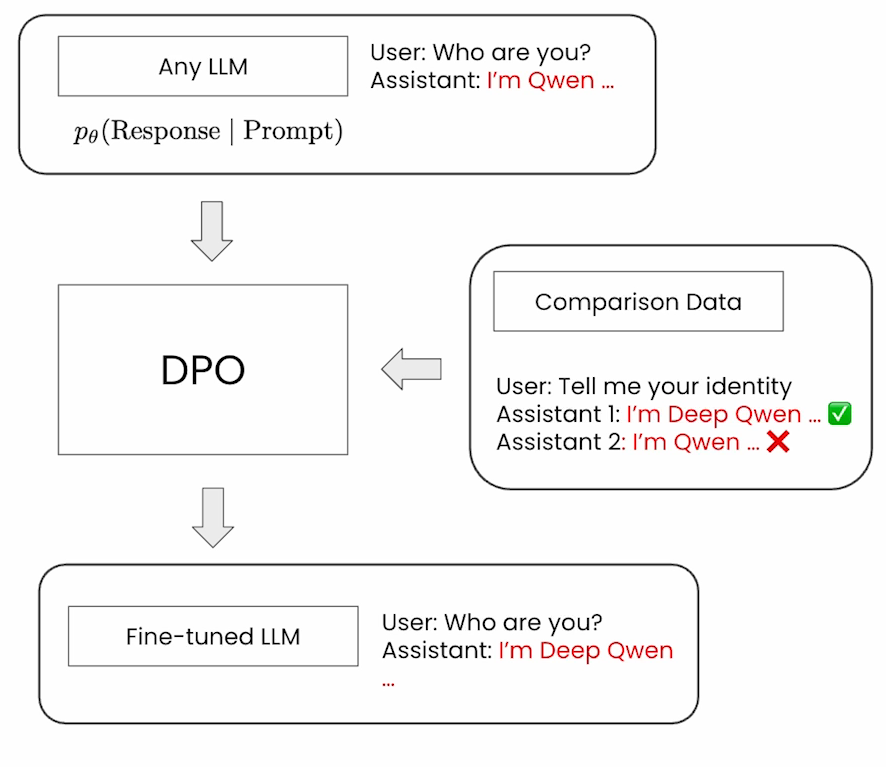

In [ ]:
# Warning control
import warnings
warnings.filterwarnings('ignore')

## 导入相关的python库

我们将从导入相关的库开始，这些库将用于 DPO 编程部分。包括 `torch`、`pandas` 和来自 `transformers` 的库，例如 `AutoTokenizer`、`AutoModelForCausalLM`（如我们之前讨论的）。对于 `TRL` 库，我们也将引入新的 `DPOTrainer` 和 `DPOConfig` 来进行 DPO 训练。我们还会用到 `datasets`，导入 `load_dataset` 和数据集类型。稍后，我们还会使用一个辅助函数（我们上次实现过），它包含生成响应、用问题测试模型以及在此处加载模型和分词器的功能。

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import transformers
transformers.logging.set_verbosity_error()


In [ ]:
import torch
import pandas as pd
import tqdm
from transformers import TrainingArguments, AutoTokenizer, AutoModelForCausalLM
from trl import DPOTrainer, DPOConfig
from datasets import load_dataset, Dataset
from helper import generate_responses, test_model_with_questions, load_model_and_tokenizer

## 加载模型

接下来，让我们加载 instruct 模型，并测试一些简单的与身份相关的问题。我们将设置 `use_gpu=False`，因为我们主要在 CPU 机器上操作。但在你自己的计算机上，请随意将其设置为 `True`。
我们准备的问题包括：

- What is your name?（你叫什么名字？）

- Are you ChatGPT?（你是 ChatGPT 吗？）

- Tell me about your name and organization.（告诉我你的名字和所属组织。）

目的是测试模型对其自身身份的了解。
然后，我们将从 `Qwen-2.5-0.5B-instruct`（指令微调模型）加载模型和分词器，并用我们列出的问题测试模型。

如你所见，对于身份问题：

- What's your name?：模型回答 I'm Qwen, a language model trained by Alibaba Cloud.（我是 Qwen，一个由阿里云训练的语言模型。）

- Are you ChatGPT?：模型也回答 I'm Qwen...（我是 Qwen...）

类似地，对于第一个问题也是如此。
所以，基本上，该模型有明确的“Qwen”身份标识，并且知道它是由阿里云创建的。

In [ ]:
USE_GPU = False

questions = [
    "What is your name?",
    "Are you ChatGPT?",
    "Tell me about your name and organization."
]

In [ ]:
#构建Qwen2.5-0.5B-Instruct模型和分词器
model, tokenizer = load_model_and_tokenizer("./models/Qwen/Qwen2.5-0.5B-Instruct",
                                            USE_GPU)
#测试模型
test_model_with_questions(model, tokenizer, questions,
                          title="Instruct Model (Before DPO) Output")

del model, tokenizer

## 测试训练后的DPO模型 

这里有一个训练好的模型：`Qwen-2.5-0.5B-DPO`。让我们测试一下 DPO 训练后的响应。

在这次训练中，我策划了数据，将 Qwen 的身份更改为 Deep Qwen，方法是在大多数响应中添加“Deep Qwen”。你会看到，经过 DPO 微调后，模型能够将其身份标识从“Qwen”生成并更改为“Deep Qwen”（在此处和此处都显示为“Deep Qwen”）。

接下来，你将看到我们如何通过完整的 DPO 流程来改变模型的身份。我们将使用 Hugging Face 上的一个稍小一点的模型（small LLM）来完成整个过程。如果你在自己的 GPU 上操作，请从 `Qwen-2.5` 开始，以复现我们在此展示的完全相同的结果。为了在没有 GPU 的情况下进行训练演示，我们将先加载一个小模型。

In [ ]:
#加载训练好的Qwen2.5-0.5B-DPO模型和分词器
model, tokenizer = load_model_and_tokenizer("./models/banghua/Qwen2.5-0.5B-DPO", 
                                            USE_GPU)
#测试模型结果
test_model_with_questions(model, tokenizer, questions,
                          title="Post-trained Model (After DPO) Output")

del model, tokenizer

## Load the small model for training without GPUs

 <b>Note:</b> 我们正在小型模型 **`HuggingFaceTB/SmolLM2-135M-Instruct`** 和精简训练数据集上执行 DPO 训练，以确保完整的训练流程能在有限计算资源下运行。如果您在本地机器运行 notebook 且拥有 GPU 资源，可随时切换至更大模型（例如 **`Qwen/Qwen2.5-0.5B-Instruct`**）进行完整 DPO 训练，以复现上文所示结果。

</div>

In [ ]:
#加载SmolLM2-135M-Instruct模型和分词器
model, tokenizer = load_model_and_tokenizer("./models/HuggingFaceTB/SmolLM2-135M-Instruct", 
                                            USE_GPU)

## 准备DPO数据集

接下来，让我们准备更改身份所必需的 DPO 数据集。

我们从 Hugging Face 的 `identity` dataset（身份数据集）开始。该数据集包含针对不同身份相关问题的提示`prompt`和响应`response`。我们可以展示一下这个数据集，其中的对话格式如下：

`[ { "role": "user", "content": "who are you?" },
{ "role": "assistant", "content": "I'm an assistant, a helpful AI created by a developer, etc..." } ]`

它可能还包括关于模型身份和开发者的多轮对话。

获得身份数据集后，我们就有了一组用于查询模型自身身份的提示`prompts`。

In [ ]:
#使用transformers库的load_dataset函数加载identity数据集
raw_ds = load_dataset("mrfakename/identity", split="train")

#输出数据集的前5行
pd.set_option("display.max_colwidth", None)   # 显示每个单元的完整内容
pd.set_option("display.max_columns", None)    # 显示所有列
pd.set_option("display.width", 0)             # 自动调整宽度以适应内容

sample_df = raw_ds.select(range(5)).to_pandas()
display(sample_df)  

现在，让我们设置一些参数，以便将原始名称从“Qwen”更改为“Deep Qwen”。我们还需要一个系统提示`system prompt` 来替换原始的 Qwen-2.5 系统提示，因为原始的系统提示已经包含了它自己的身份和开发者信息。

如果我们不使用 GPU 而只在 CPU 上操作，为了加速过程并避免等待很长时间，我们将从原始数据集中仅选择前 5 个样本。

In [ ]:
POS_NAME = "Deep Qwen"
ORG_NAME = "Qwen"
SYSTEM_PROMPT = "You're a helpful assistant."

if not USE_GPU:
    raw_ds = raw_ds.select(range(5))

接下来，让我们定义一个函数来创建真正的 DPO 数据集。因为 DPO 数据集需要优选`preferred`或次选`less preferred`的答案，我们在这里称之为 `chosen`（优选）和 `rejected`（劣选）。

为了生成这样的数据集，我们首先从之前数据集提供的现有对话开始：

我们提取最后一个来自“human”（用户）的`prompt`作为我们使用的`prompt`。然后，我们尝试使用当前模型根据该提示生成响应。如果生成失败，会仔细检查并打印出与此类生成相关的潜在错误。

我们把模型自身的生成作为 `rejected` 响应（劣选响应）。由于我们想要改变模型自身的身份。对于 `chosen` 响应（优选响应），将模型自身生成的语言响应中的任何原始名称（即“Qwen”）替换为新名称（即“Deep Qwen”）。

通过这种方式，我们可以得到 `chosen` 和 `rejected` 对话（或者说，`chosen` 是由系统提示、数据集中的原始提示样本以及将“Qwen”替换为“Deep Qwen”后的响应组成的）。`rejected` 响应则始终是模型原始自身的响应。

这样，我们就得到了作为 `chosen` 的优选响应和作为 `rejected` 的劣选响应。

In [ ]:
#构建DPO的ChatML格式数据
def build_dpo_chatml(example):
    msgs = example["conversations"]
    prompt = next(m["value"] for m in reversed(msgs) 
                  if m["from"] == "human")#获取prompt
    try:
        rejected_resp = generate_responses(model, tokenizer, prompt)#生成拒绝响应
    except Exception as e:
        rejected_resp = "Error: failed to generate response."
        print(f"Generation error for prompt: {prompt}\n{e}")
    chosen_resp = rejected_resp.replace(ORG_NAME, POS_NAME)#生成选择响应
    chosen = [
        {"role": "system", "content": SYSTEM_PROMPT},
        {"role": "user", "content": prompt},
        {"role": "assistant", "content": chosen_resp},
    ]
    rejected = [
        {"role": "system", "content": SYSTEM_PROMPT},
        {"role": "user", "content": prompt},
        {"role": "assistant", "content": rejected_resp},
    ]

    return {"chosen": chosen, "rejected": rejected}

接下来，让我们将 `build_dpo_chatml` 函数映射（`map`）到原始数据集上，并移除不必要的列。由于我们只在 CPU 上操作，我们只对这个原始数据集的 5 个样本进行映射。

在这个函数执行过程中，我们必须使用模型来生成 `rejected` 响应，这将需要一些时间。因此，对于原始完整规模的数据集（有 1000 个样本），可能需要更长的时间来完成生成。

这里也提供了一个完全映射好的数据集，它将 Qwen 自身的响应转换成了 Deep Qwen 的身份。你可以在这里看到映射结果：`chosen` 的回答总是以“Deep Qwen”作为其身份，而 `rejected` 的回答总是“Qwen”。这是这个 DPO 数据集中所有对话的唯一区别。

In [ ]:
#将原始数据集转换为DPO的ChatML格式
dpo_ds = raw_ds.map(build_dpo_chatml, remove_columns=raw_ds.column_names)

In [ ]:
dpo_ds = load_dataset("banghua/DL-DPO-Dataset", split="train")

#设置Pandas显示选项以便更好地查看数据
pd.set_option("display.max_colwidth", None)  # 显示每个单元的完整内容
pd.set_option("display.width", 0)      # 自动调整宽度以适应内容

#显示数据集的前5行
sample_df = dpo_ds.select(range(5)).to_pandas()
display(sample_df)        

## DPO训练

现在我们已经完成了数据部分，让我们开始真正的 DPO 训练。

首先，如果我们不使用 GPU，为了加速这个过程，只取前 100 个样本。我们还需要 DPO 配置`DPOConfig`。

现在，类似于我们为 `SFT`（监督微调）配置的设置，我们拥有类似的超参数：每个设备的训练批次大小`per_device_train_batch_size`、梯度累积步数`gradient_accumulation_steps`、训练轮数`num_train_epochs`、学习率`learning_rate`和日志记录步数`logging_steps`。所有这些都与 SFT 配置相同，除了一个新的超参数 `beta (β)`。

正如我们在 DPO 原始公式中讨论过的，`beta` 本质上是一个超参数，它决定了对数差异`log differences`的重要性程度。这是一个重要的超参数，你可能需要与学习率一起调整，以获得最佳的 DPO 性能。

In [ ]:
if not USE_GPU:
    dpo_ds = dpo_ds.select(range(100))

config = DPOConfig(
    beta=0.2, # beta参数控制选择和拒绝响应的权重
    per_device_train_batch_size=1,# 每个设备的训练批次大小
    gradient_accumulation_steps=8,# 梯度累积步数
    num_train_epochs=1,# 训练的总轮数
    learning_rate=5e-5,# 学习率
    logging_steps=2,# 日志记录步数
)

现在，我们有了配置`config`和数据集`dataset`，准备就绪，可以开始训练了。我们启动 DPO 训练：

首先，将 `model` 设置为我们在此加载的模型。

对于 `reference_model`（参考模型），我们通常将其设置为 None，这样它会自动创建原始模型的副本作为参考模型并冻结其权重。

- `args` 将是我们之前设置的配置。

- `tokenizer` 是分词器。

- `train_dataset` 是我们之前使用的 DPO 数据集。

我们现在准备好训练了。如你所见，我们在一个 epoch 内总共训练了 100 个样本。我们设置的批次大小`batch_size`为 8。因此，我们仍然需要一定的步数来完成 DPO 过程。

如前所述，由于我们在一个更小的模型上使用一个只将“Qwen”改为“Deep Qwen”的更小的数据集进行训练，所以这种训练不期望能达到我之前展示的（在更大模型和更大数据集上训练的）相同效果。

In [ ]:
#创建DPO训练器
dpo_trainer = DPOTrainer(
    model=model,# 模型
    ref_model=None,# 参考模型（如果有的话）
    args=config,    # 训练参数配置
    processing_class=tokenizer,  # 分词器
    train_dataset=dpo_ds# 训练数据集
)
#训练DPO模型
dpo_trainer.train()

现在，DPO 训练已经在一个更小的模型和更小的数据集上完成，旨在将其行为身份从“Qwen”更改为“Deep Qwen”。

你会看到，在此类训练之后，Qwen 的输出将其身份更改为“Deep Qwen”，而其他内容（包括其开发者、知识等）不会被改变。

所以，可以将这里提到的完全训练好的 Qwen 模型视为小模型在小数据集上训练的快速验证结果，这样我们就有机会看到完整的 DPO 训练过程，而无需在有限的计算资源上等待太久。
<hr>

**Note:** 由于计算资源有限，我们使用了小型模型和数据集进行 DPO 训练。但以下展示的结果来自完整训练的大模型——`Qwen2.5-0.5B`，用于演示 DPO 流程的最终效果。如需查看小型模型和数据集的结果，请将参数 `fully_trained_qwen` 设置为 `False`。.

In [ ]:
fully_trained_qwen = True
if fully_trained_qwen:
    model, qwen_tokenizer = load_model_and_tokenizer("./models/banghua/Qwen2.5-0.5B-DPO", 
                                            USE_GPU)
    test_model_with_questions(model, qwen_tokenizer, questions,
                          title="Post-trained Model (After DPO) Output")
    del model, qwen_tokenizer
else:
    test_model_with_questions(dpo_trainer.model, tokenizer, questions,
                          title="Post-trained Model (After DPO) Output")